# CIDACS-RL params tuning lab (PyGAD)

This notebook tunes **weights + penalties** using a **Genetic Algorithm (GA)** with **PyGAD**.

We assume you have an *experiments dataset* with:
- 10 params (genes)
- TP/FP/TN/FN
- so we can compute metrics (precision/accuracy/etc.)

So the GA here does **NOT** run linkage (too slow). It searches params and scores candidates using:
- exact lookup (if method=exact), or
- a kNN surrogate (method=knn)

simple lab, good for quick iteration.


## GA / PyGAD theory (step-by-step)

PyGAD runs a standard **Genetic Algorithm**.

**Goal**: find \(\theta\) that maximizes fitness \(f(\theta)\).
- \(\theta\) = gene vector (your 10 params)
- \(f\) = objective metric computed from TP/FP/TN/FN

### One generation loop
1) **Init population**: build `sol_per_pop` random solutions from `gene_space`  
2) **Evaluate fitness**: compute `fitness[i] = f(Si)` for each solution  
3) **Select parents**: prefer higher fitness (tournament / roulette / rank)  
4) **Crossover**: mix parents into kids (single-point / uniform / etc.)  
5) **Mutation**: randomly change some genes (exploration, escape local maxima)  
6) **Next population**: keep some parents/elites + fill with kids  
Repeat for `num_generations` or stop early (`stop_criteria`).

Notes:
- linkage metrics can be jagged (threshold-ish), GA can still handle it.
- optimizing only precision may push you to "link less". f1/fbeta is often more balanced.


# Preamble (Imports and SparkSession)

In [33]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pyspark.sql.types as T
from pyspark.storagelevel import StorageLevel
from pyspark.sql import SparkSession

In [34]:
import pandas as pd
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

In [35]:
spark = SparkSession.builder \
    .appName("TrainDataSet") \
    .master("spark://barravento:7077") \
    .config("spark.es.nodes", "barravento") \
    .config("spark.es.port", "9200") \
    .config("spark.es.nodes.wan.only", "false") \
    .config("spark.es.resource", "dbb2") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.shuffle.partitions", 16) \
    .config("spark.sql.files.maxPartitionBytes", "256m") \
    .getOrCreate()

sc = spark.sparkContext
# just to ensure that 
sc.setCheckpointDir("hdfs://barravento:9000/spark-checkpoints")

## Load config (YAML)

Edit the YAML to point to your dataset and tune GA knobs.


In [55]:
import yaml
from pathlib import Path

CONFIG_PATH = Path("03_ga_config.yaml")  # <- change if needed

with open(CONFIG_PATH, "r") as f:
    cfg = yaml.safe_load(f)

cfg

{'data': {'experiments_path': 'hdfs://barravento:9000/data/result/train_dataset_final.parquet',
  'format': 'parquet',
  'gene_columns': ['w_nome',
   'w_nome_mae',
   'w_dt_nasc',
   'w_sexo',
   'p_nome',
   'p_nome_mae',
   'p_dt_nasc',
   'p_sexo'],
  'count_columns': ['VP', 'FP', 'VN', 'FN']},
 'objective': {'name': 'accuracy', 'params': {'beta': 1.0}},
 'ga': {'random_seed': 123,
  'num_generations': 60,
  'sol_per_pop': 30,
  'num_parents_mating': 10,
  'parent_selection_type': 'tournament',
  'K_tournament': 3,
  'keep_parents': 2,
  'crossover_type': 'single_point',
  'mutation_type': 'random',
  'mutation_percent_genes': 20,
  'stop_criteria': ['reach_0.98']},
 'search_space': {'w_nome': {'low': 0.0, 'high': 3.0, 'step': 0.05},
  'w_nome_mae': {'low': 0.0, 'high': 3.0, 'step': 0.05},
  'w_dt_nasc': {'low': 0.0, 'high': 3.0, 'step': 0.05},
  'w_sexo': {'low': 0.0, 'high': 1.0, 'step': 0.05},
  'p_nome': {'low': 0.0, 'high': 2.0, 'step': 0.05},
  'p_nome_mae': {'low': 0.0, 'hig

## Load experiments dataset (local or HDFS)

- If `data.format = parquet`: we load parquet *dataset folders* (Spark style) too.
- If `data.format = csv`: we load all `*.csv` files in the folder (Spark part files).

For HDFS (`hdfs://host:port/path`), we use **pyarrow.fs**.


In [56]:
experiments_path = cfg["data"]["experiments_path"]

df_spark = spark.read.parquet(experiments_path)
df = df_spark.toPandas()

In [57]:
df.head()

,VP,FP,FN,VN,precision,recall,specificity,accuracy,w_nome,p_nome,w_nome_mae,p_nome_mae,w_dt_nasc,p_dt_nasc,w_sexo,p_sexo
0,422.0,15.0,138.0,425.0,0.965675,0.753571,0.965909,0.847,5.15,0.18,0.15,0.64,2.20,0.47,0.45,0.37
1,435.0,13.0,125.0,427.0,0.970982,0.776786,0.970455,0.862,3.85,0.35,5.00,0.79,4.25,0.91,4.35,0.17
2,301.0,0.0,259.0,440.0,1.000000,0.537500,1.000000,0.741,5.15,0.65,0.55,0.30,1.00,0.97,4.40,0.92
3,431.0,14.0,129.0,426.0,0.968539,0.769643,0.968182,0.857,1.70,0.64,3.65,0.76,0.70,0.52,3.85,0.83
4,423.0,15.0,137.0,425.0,0.965753,0.755357,0.965909,0.848,3.95,0.45,2.75,0.34,0.95,0.28,0.85,0.22


In [58]:
df.shape

(50, 16)

## Metrics from TP/FP/TN/FN


In [59]:
def safe_div(a, b):
    return a / b if b != 0 else 0.0

def metric_from_counts(tp, fp, tn, fn, name="precision", beta=1.0):
    tp, fp, tn, fn = float(tp), float(fp), float(tn), float(fn)

    precision = safe_div(tp, tp + fp)
    recall = safe_div(tp, tp + fn)
    accuracy = safe_div(tp + tn, tp + tn + fp + fn)

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    if (beta**2 * precision + recall) == 0:
        fbeta = 0.0
    else:
        fbeta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)

    tnr = safe_div(tn, tn + fp)
    bal_acc = 0.5 * (recall + tnr)

    name = name.lower()
    if name == "precision":
        return precision
    if name == "recall":
        return recall
    if name == "accuracy":
        return accuracy
    if name == "f1":
        return f1
    if name in ("fbeta", "f_beta", "f-beta"):
        return fbeta
    if name in ("balanced_accuracy", "balanced-accuracy", "bal_acc"):
        return bal_acc

    raise ValueError(f"Unknown objective.name: {name}")


## Build scorer (exact or kNN surrogate)


In [60]:
GENE_COLS = cfg["data"]["gene_columns"]
COUNT_COLS = cfg["data"]["count_columns"]

objective_name = cfg["objective"]["name"]
beta = float(cfg["objective"].get("params", {}).get("beta", 1.0))

method = cfg["surrogate"]["method"].lower()
k = int(cfg["surrogate"].get("k", 15))
standardize = bool(cfg["surrogate"].get("standardize", True))

X = df[GENE_COLS].to_numpy(dtype=float)
C = df[COUNT_COLS].to_numpy(dtype=float)

if standardize:
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma[sigma == 0] = 1.0
    Xn = (X - mu) / sigma
else:
    mu = None
    sigma = None
    Xn = X

round_ndigits = 6
exact_map = None
if method == "exact":
    exact_map = {}
    for row in df.itertuples(index=False):
        key = tuple(round(getattr(row, c), round_ndigits) for c in GENE_COLS)
        tp, fp, tn, fn = (getattr(row, COUNT_COLS[i]) for i in range(4))
        exact_map[key] = (tp, fp, tn, fn)

def score_solution(solution):
    sol = np.array(solution, dtype=float)

    if method == "exact":
        key = tuple(round(v, round_ndigits) for v in sol.tolist())
        if key not in exact_map:
            return 0.0
        tp, fp, tn, fn = exact_map[key]
        return metric_from_counts(tp, fp, tn, fn, name=objective_name, beta=beta)

    if standardize:
        soln = (sol - mu) / sigma
    else:
        soln = sol

    dists = np.linalg.norm(Xn - soln[None, :], axis=1)
    kk = min(k, len(dists))
    idx = np.argpartition(dists, kk-1)[:kk]
    w = 1.0 / (dists[idx] + 1e-12)
    w = w / w.sum()
    avg = (C[idx] * w[:, None]).sum(axis=0)
    tp, fp, tn, fn = avg
    return metric_from_counts(tp, fp, tn, fn, name=objective_name, beta=beta)

score_solution(X[0])

0.8470000000000418

## Build gene_space from `search_space`


In [61]:
df_spark.columns

['VP',
 'FP',
 'FN',
 'VN',
 'precision',
 'recall',
 'specificity',
 'accuracy',
 'w_nome',
 'p_nome',
 'w_nome_mae',
 'p_nome_mae',
 'w_dt_nasc',
 'p_dt_nasc',
 'w_sexo',
 'p_sexo']

In [62]:
def expand_space(spec):
    low = float(spec["low"]); high = float(spec["high"]); step = float(spec["step"])
    n = int(np.floor((high - low) / step + 1e-9)) + 1
    vals = [low + i*step for i in range(n)]
    vals = [v for v in vals if v <= high + 1e-9]
    return vals

gene_space = [expand_space(cfg["search_space"][c]) for c in GENE_COLS]
[len(v) for v in gene_space], gene_space[0][:5]

([61, 61, 61, 21, 41, 41, 41, 21], [0.0, 0.05, 0.1, 0.15000000000000002, 0.2])

## Run PyGAD


In [63]:
import random
import pygad

seed = int(cfg["ga"].get("random_seed", 42))
np.random.seed(seed)
random.seed(seed)

def fitness_func(ga_instance, solution, solution_idx):
    return score_solution(solution)

ga_cfg = cfg["ga"]

ga = pygad.GA(
    random_seed=seed,
    num_generations=int(ga_cfg["num_generations"]),
    sol_per_pop=int(ga_cfg["sol_per_pop"]),
    num_parents_mating=int(ga_cfg["num_parents_mating"]),
    num_genes=len(GENE_COLS),
    gene_space=gene_space,
    parent_selection_type=ga_cfg.get("parent_selection_type", "tournament"),
    K_tournament=int(ga_cfg.get("K_tournament", 3)),
    keep_parents=int(ga_cfg.get("keep_parents", 0)),
    crossover_type=ga_cfg.get("crossover_type", "single_point"),
    mutation_type=ga_cfg.get("mutation_type", "random"),
    mutation_percent_genes=int(ga_cfg.get("mutation_percent_genes", 10)),
    stop_criteria=ga_cfg.get("stop_criteria", None),
    fitness_func=fitness_func,
)

ga.run()

best_sol, best_fit, _ = ga.best_solution()
best_fit, dict(zip(GENE_COLS, best_sol))


(0.9452840695363122,
 {'w_nome': 1.05,
  'w_nome_mae': 2.6500000000000004,
  'w_dt_nasc': 3.0,
  'w_sexo': 0.2,
  'p_nome': 0.6000000000000001,
  'p_nome_mae': 0.5,
  'p_dt_nasc': 0.6000000000000001,
  'p_sexo': 0.15000000000000002})

## Compare vs best row in the table


In [64]:
df["_objective"] = [
    metric_from_counts(tp, fp, tn, fn, name=objective_name, beta=beta)
    for tp, fp, tn, fn in df[COUNT_COLS].to_numpy()
]

best_table = float(df["_objective"].max())
best_table, float(best_fit)


(0.986, 0.9452840695363122)

## Plot progress


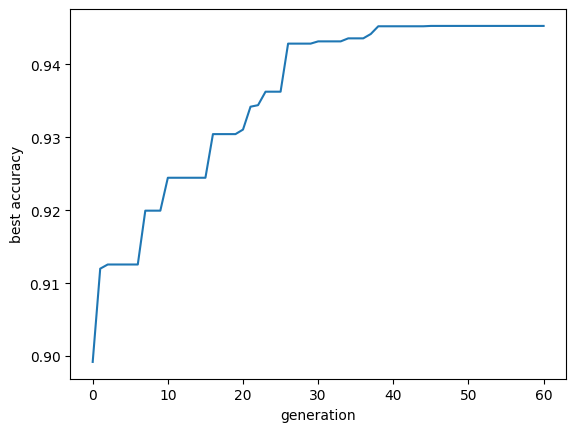

In [65]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(ga.best_solutions_fitness)
plt.xlabel("generation")
plt.ylabel(f"best {objective_name}")
plt.show()
